2025-05-03 13:17:34,855 - INFO - Testing checkpoint final
2025-05-03 13:17:34,856 - INFO - Loading base model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

2025-05-03 13:17:37,218 - INFO - Using GPU for inference
2025-05-03 13:17:37,219 - INFO - Loading LoRA weights from: models/sd15_lora_logos/final
2025-05-03 13:17:37,769 - INFO - Loaded state dict with 192 keys
2025-05-03 13:17:37,771 - INFO - Found 64 attention modules to apply LoRA
2025-05-03 13:17:37,772 - INFO - Applied LoRA to 0 modules
2025-05-03 13:17:37,774 - INFO - Using seed: 385890
2025-05-03 13:17:37,774 - INFO - Generating sample 1/2 for prompt: A logo for a bakery named 'Sweet Delights', vintage style, with pastel colors and a cupcake icon


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:17:42,168 - INFO - Generating sample 2/2 for prompt: A logo for a bakery named 'Sweet Delights', vintage style, with pastel colors and a cupcake icon


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:17:46,057 - INFO - Generating sample 1/2 for prompt: A logo for a photography studio named 'Capture Moments', minimalist style, with camera icon and black/gold colors


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:17:49,967 - INFO - Generating sample 2/2 for prompt: A logo for a photography studio named 'Capture Moments', minimalist style, with camera icon and black/gold colors


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:17:53,909 - INFO - Generating sample 1/2 for prompt: A logo for a tech startup named 'CodeCraft', modern style, with angular typography and blue/green gradient


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:17:57,865 - INFO - Generating sample 2/2 for prompt: A logo for a tech startup named 'CodeCraft', modern style, with angular typography and blue/green gradient


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:01,824 - INFO - Generating sample 1/2 for prompt: A logo for a bookstore named 'Page Turner', classic style, with an open book icon and serif typography


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:05,767 - INFO - Generating sample 2/2 for prompt: A logo for a bookstore named 'Page Turner', classic style, with an open book icon and serif typography


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:09,684 - INFO - Generating sample 1/2 for prompt: A logo for an eco-friendly cleaning company named 'GreenClean', with leaf motif and teal/green colors


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:13,580 - INFO - Generating sample 2/2 for prompt: A logo for an eco-friendly cleaning company named 'GreenClean', with leaf motif and teal/green colors


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:17,460 - INFO - Generating sample 1/2 for prompt: A logo for a children's toy store named 'Wonder World', playful style, with colorful building blocks


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:21,320 - INFO - Generating sample 2/2 for prompt: A logo for a children's toy store named 'Wonder World', playful style, with colorful building blocks


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:25,177 - INFO - Generating sample 1/2 for prompt: A logo for a music studio named 'SoundWave', with audio waveform incorporated into text, purple color scheme


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:29,012 - INFO - Generating sample 2/2 for prompt: A logo for a music studio named 'SoundWave', with audio waveform incorporated into text, purple color scheme


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:32,836 - INFO - Generating sample 1/2 for prompt: A logo for a travel agency named 'Horizon Adventures', with subtle mountain and airplane silhouettes


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-03 13:18:36,653 - INFO - Generating sample 2/2 for prompt: A logo for a travel agency named 'Horizon Adventures', with subtle mountain and airplane silhouettes


  0%|          | 0/50 [00:00<?, ?it/s]

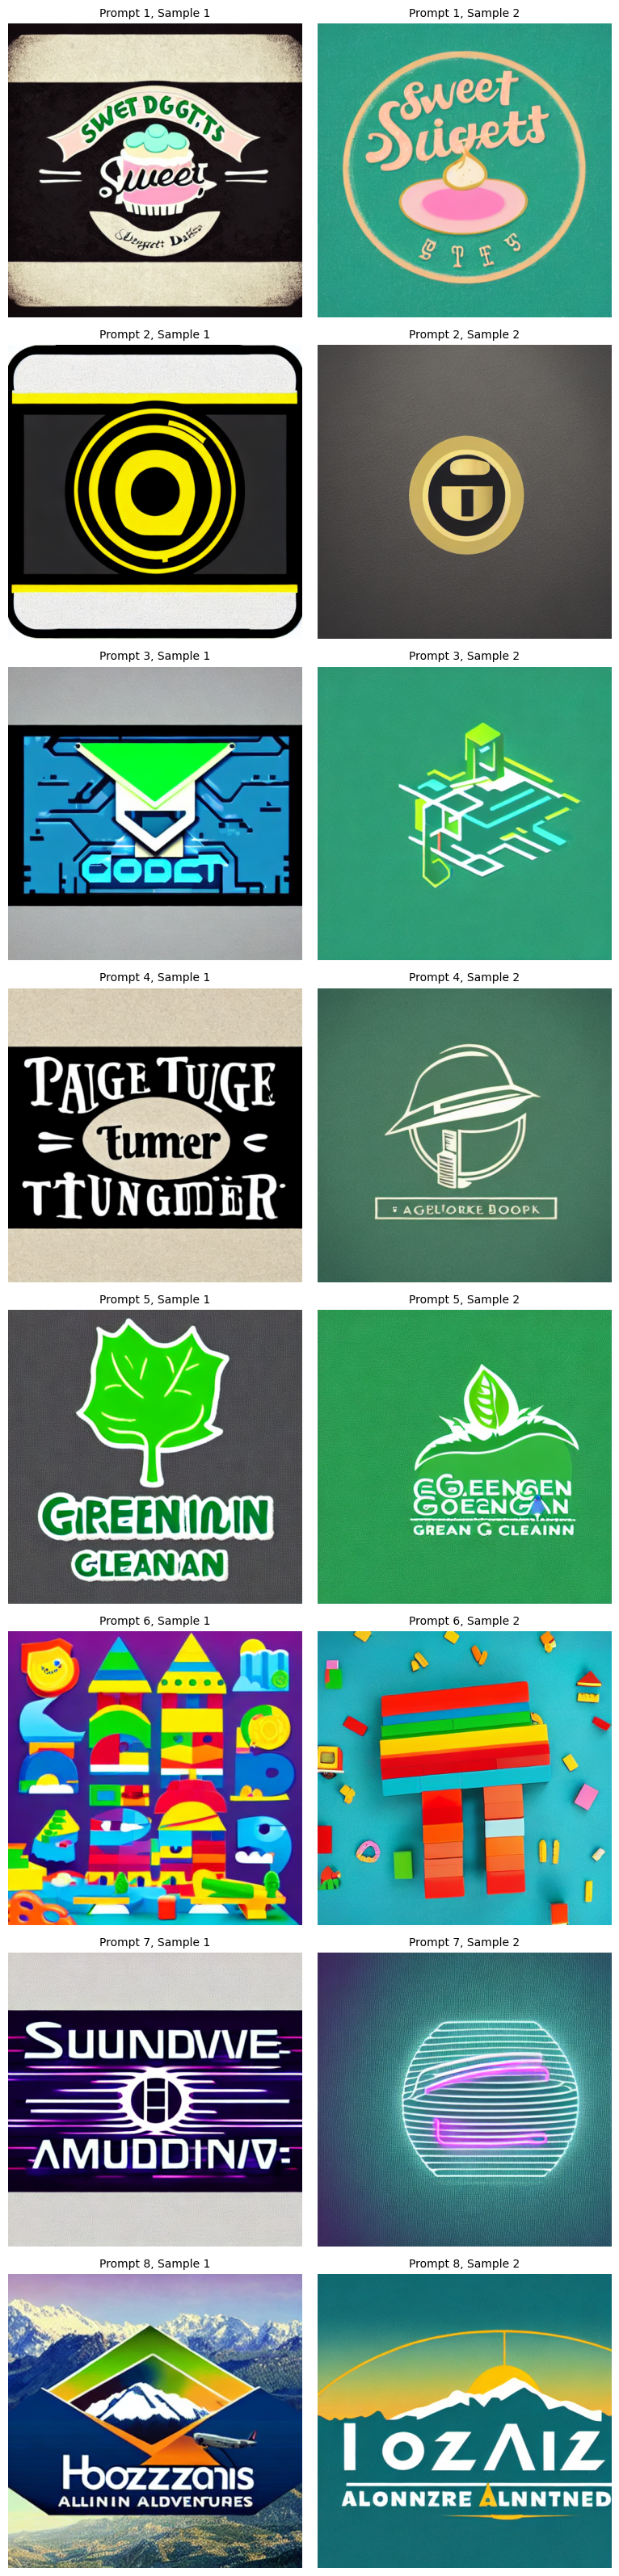

In [2]:
# Importing required Dependencies

import os
import torch
import argparse
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import random

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_lora_model(checkpoint_path, base_model="runwayml/stable-diffusion-v1-5"):
    """Loading the base model and apply LoRA weights from checkpoint"""
    logger.info(f"Loading base model: {base_model}")
    
    # Loading the base pipeline
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    # Move to GPU if available
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
        logger.info("Using GPU for inference")
    else:
        logger.info("Using CPU for inference (slow)")
    
    # Loading and applying LoRA weights
    if checkpoint_path:
        logger.info(f"Loading LoRA weights from: {checkpoint_path}")
        
        # Loading the safetensors file
        import safetensors.torch
        weights_file = os.path.join(checkpoint_path, "pytorch_lora_weights.safetensors")
        
        if not os.path.exists(weights_file):
            logger.error(f"Weights file not found: {weights_file}")
            return pipe
        
        state_dict = safetensors.torch.load_file(weights_file)
        logger.info(f"Loaded state dict with {len(state_dict)} keys")
        
        # Creating a custom forward function for attention modules
        def add_lora_to_module(module_name, module):
            """Add LoRA to specific modules"""
            orig_forward = module.forward
            
            def forward_with_lora(hidden_states, *args, **kwargs):
                # Original output
                output = orig_forward(hidden_states, *args, **kwargs)
                
                # Getting module path in state dict format
                module_path = module_name.replace(".", "_")
                
                # Checking if we have LoRA weights for this module
                lora_down_key = f"{module_path}.lora_down.weight"
                lora_up_key = f"{module_path}.lora_up.weight"
                scale_key = f"{module_path}.scale"
                
                if lora_down_key in state_dict and lora_up_key in state_dict:
                    # Getting LoRA weights
                    lora_down = state_dict[lora_down_key].to(hidden_states.device, hidden_states.dtype)
                    lora_up = state_dict[lora_up_key].to(hidden_states.device, hidden_states.dtype)
                    
                    # Get scale (or default to 1.0)
                    scale = 1.0
                    if scale_key in state_dict:
                        if isinstance(state_dict[scale_key], torch.Tensor):
                            scale = state_dict[scale_key].item()
                        else:
                            scale = state_dict[scale_key]
                    
                    # Applying LoRA
                    # hidden_states: [batch, seq_len, dim]
                    # lora_down: [rank, dim]
                    if hidden_states.dim() == 3:
                        # Reshape for batch processing
                        batch, seq_len, dim = hidden_states.shape
                        h_flat = hidden_states.reshape(-1, dim)
                        
                        # Appling LoRA
                        lora_output = h_flat @ lora_down.t() @ lora_up
                        lora_output = lora_output.reshape(batch, seq_len, -1)
                        
                        # Adding to original output with scaling
                        output = output + (scale * lora_output)
                
                return output
            
            # Replacing forward method
            module.forward = forward_with_lora
        
        # Applying LoRA to attention modules
        attn_modules = []
        for name, module in pipe.unet.named_modules():
            if "attn1.to_q" in name or "attn1.to_k" in name or "attn1.to_v" in name or "attn1.to_out.0" in name:
                attn_modules.append((name, module))
        
        logger.info(f"Found {len(attn_modules)} attention modules to apply LoRA")
        
        # Applying LoRA to each module
        lora_count = 0
        for name, module in attn_modules:
            # Converting module name format to state dict format
            module_name = name
            
            # Checking if this module has LoRA weights
            module_path = module_name.replace(".", "_")
            lora_down_key = f"{module_path}.lora_down.weight"
            lora_up_key = f"{module_path}.lora_up.weight"
            
            if lora_down_key in state_dict and lora_up_key in state_dict:
                add_lora_to_module(module_name, module)
                lora_count += 1
        
        logger.info(f"Applied LoRA to {lora_count} modules")
    
    return pipe

def generate_logos(pipe, prompts, num_samples=4, seed=None, **kwargs):
    """Generate logo samples for each prompt"""
    results = {}
    
    # Setting a generator for reproducibility if seed is provided
    generator = None
    if seed is not None:
        generator = torch.Generator(device=pipe.device).manual_seed(seed)
        logger.info(f"Using seed: {seed}")
    
    # Generating images for each prompt
    for prompt in prompts:
        images = []
        
        # Generating multiple samples per prompt
        for i in range(num_samples):
            logger.info(f"Generating sample {i+1}/{num_samples} for prompt: {prompt}")
            
            # Setting a different seed for each sample if a base seed is provided
            sample_generator = None
            if generator is not None:
                sample_generator = torch.Generator(device=pipe.device).manual_seed(seed + i)
            
            # Generating image
            image = pipe(
                prompt, 
                num_inference_steps=50,
                guidance_scale=7.5,
                generator=sample_generator,
                **kwargs
            ).images[0]
            
            images.append(image)
        
        # Storing results for this prompt
        results[prompt] = images
    
    return results

def display_results(all_results, num_samples=4, save_path=None):
    """Display and optionally save the generated images"""
    # Counting total number of prompts across all checkpoints
    total_prompts = len(next(iter(all_results.values())))
    
    # Creating a figure with subplots
    fig, axes = plt.subplots(
        len(all_results), 
        total_prompts * num_samples, 
        figsize=(num_samples * 4 * total_prompts, 5 * len(all_results))
    )
    
    # If only one checkpoint, wrap axes in a list for consistency
    if len(all_results) == 1:
        axes = [axes]
    
    # Flatten axes if only one prompt
    if total_prompts == 1 and num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot the images
    for i, (checkpoint, results) in enumerate(all_results.items()):
        ax_index = 0
        
        for prompt, images in results.items():
            for j, image in enumerate(images):
                # Getting the correct axis
                ax = axes[i][ax_index]
                
                # Displaying image
                ax.imshow(image)
                
                # Setting title - first row includes prompt
                if i == 0:
                    if j == 0:
                        ax.set_title(f"Prompt: {prompt}\nSample {j+1}", fontsize=10)
                    else:
                        ax.set_title(f"Sample {j+1}", fontsize=10)
                else:
                    if j == 0:
                        ax.set_title(f"Sample {j+1}", fontsize=10)
                    else:
                        ax.set_title(f"Sample {j+1}", fontsize=10)
                
                # Setting checkpoint label on the left
                if j == 0:
                    ax.set_ylabel(f"Checkpoint: {checkpoint}", fontsize=12)
                
                # Remove ticks
                ax.set_xticks([])
                ax.set_yticks([])
                
                ax_index += 1
    
    # Adjust layout
    plt.tight_layout()
    
    # Saving if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        logger.info(f"Results saved to: {save_path}")
    
    # Showing plot
    plt.show()

def generate_comparison(checkpoints, prompts, num_samples=4, seed=42):
    """Generating and comparing logos from different checkpoints"""
    all_results = {}
    
    # Generating results for each checkpoint
    for checkpoint in checkpoints:
        logger.info(f"Processing checkpoint: {checkpoint}")
        
        # Creating checkpoint path
        checkpoint_path = f"models/sd15_lora_logos/checkpoint-{checkpoint}"
        
        # Loading the model
        pipe = load_lora_model(checkpoint_path)
        
        # Generating logos
        results = generate_logos(pipe, prompts, num_samples=num_samples, seed=seed)
        
        # Storing results
        all_results[checkpoint] = results
        
        # Clear GPU memory
        del pipe
        torch.cuda.empty_cache()
    
    # Displaying and save comparison
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"results/logo_comparison_{timestamp}.png"
    display_results(all_results, num_samples=num_samples, save_path=save_path)
    
    return all_results

def test_checkpoint(checkpoint, prompts, num_samples=4, seed=42):
    """Testing a single checkpoint with the given prompts"""
    logger.info(f"Testing checkpoint {checkpoint}")
    
    # Creating checkpoint path
    if checkpoint == "final":
        checkpoint_path = f"models/sd15_lora_logos/final"
    else:
        checkpoint_path = f"models/sd15_lora_logos/checkpoint-{checkpoint}"
    
    # Loading the model
    pipe = load_lora_model(checkpoint_path)
    
    # Generating logos
    results = generate_logos(pipe, prompts, num_samples=num_samples, seed=seed)
    
    # Displaying results
    plt.figure(figsize=(num_samples * 4, len(prompts) * 4))
    
    for i, (prompt, images) in enumerate(results.items()):
        for j, image in enumerate(images):
            plt.subplot(len(prompts), num_samples, i * num_samples + j + 1)
            plt.imshow(image)
            plt.title(f"Prompt {i+1}, Sample {j+1}", fontsize=10)
            plt.axis('off')
    
    plt.tight_layout()
    
    # Saving results
    os.makedirs("results", exist_ok=True)
    save_path = f"results/checkpoint_{checkpoint}_results.png"
    plt.savefig(save_path)
    
    plt.show()
    
    # Clearing GPU memory
    del pipe
    torch.cuda.empty_cache()
    
    return results

# Calling Main
if __name__ == "__main__":
    # Testing prompts
    test_prompts = [
        "A logo for a bakery named 'Sweet Delights', vintage style, with pastel colors and a cupcake icon",
        "A logo for a photography studio named 'Capture Moments', minimalist style, with camera icon and black/gold colors",
        "A logo for a tech startup named 'CodeCraft', modern style, with angular typography and blue/green gradient",
        "A logo for a bookstore named 'Page Turner', classic style, with an open book icon and serif typography",
        "A logo for an eco-friendly cleaning company named 'GreenClean', with leaf motif and teal/green colors",
        "A logo for a children's toy store named 'Wonder World', playful style, with colorful building blocks",
        "A logo for a music studio named 'SoundWave', with audio waveform incorporated into text, purple color scheme",
        "A logo for a travel agency named 'Horizon Adventures', with subtle mountain and airplane silhouettes"
    ]
    
    # Generating comparison
    test_checkpoint("final", test_prompts[:8], num_samples=2, seed=random.randint(0, 999999))